/tmp/ipykernel_2391542/344948567.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  llm_exam_result = llm_exam_result.append({"Model": model, "QuestionIndex": index_question, "SamplingIndex": sample_Index, "NumberOfCorrectLLMAnswers": num_of_correct_llm_answer, "NumberOfCorrectExamAnswers": num_of_correct_answer, "Ratio": num_of_correct_llm_answer/num_of_correct_answer, "LLM_Answer": answerLLm, "Exam_Answers": answer_exam_with_whitespace, "Answered_Correctly" : answered_correctly, "Too_Many_answers": too_many_answers}, ignore_index=True)
/tmp/ipykernel_2391542/344948567.py:272: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  llm_exam_result = llm_exam_result.append({"Model": model, "QuestionIndex": index_question, "SamplingIndex": sample_Index, "NumberOfCorrectLLMAnswers": num_of_correct_llm_answer, "NumberOfC

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,5,1,1,1.000000,"[A, B]",A,False,True
1,Mixtral-8x-7b,1,1,1,1,1.000000,[C],C,True,False
2,Mixtral-8x-7b,2,0,0,1,0.000000,[B],A,False,False
3,Mixtral-8x-7b,3,1,0,1,0.000000,[B],A,False,False
4,Mixtral-8x-7b,4,0,0,2,0.000000,"[A, B]",D E,False,False
5,Mixtral-8x-7b,5,9,1,1,1.000000,"[A, D]",A,False,True
6,Mixtral-8x-7b,6,1,1,1,1.000000,[C],C,True,False
7,Mixtral-8x-7b,7,0,1,1,1.000000,[A],A,True,False
8,Mixtral-8x-7b,8,0,0,1,0.000000,"[C, D]",A,False,True
9,Mixtral-8x-7b,9,1,1,3,0.333333,"[A, C, D]",B D F,False,False


KeyError: 'Model'

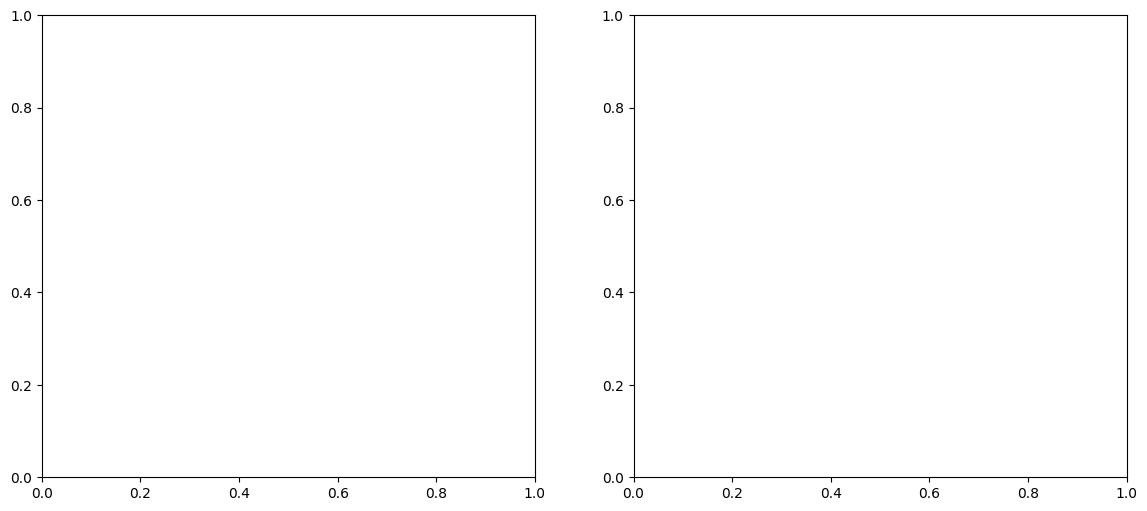

In [11]:
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
import pandas as pd
from langchain import PromptTemplate
import re
import matplotlib.pyplot as plt
from prompt_templates import *


#Valid Answers:
"""
    "Correct Answer: ['A','D']", 
    "Correct Answer: ['A']",
    "Correct Answer: [A]",
    "Correct Answer: [a]",
    "Correct Answer: [a,b]",
    "Correct Answer: [A,b]",
    "Correct Answer: ['a']",
    "Correct Answer: ['a','b']",
"""
def is_valid_answer(answer):
    """Checks if the provided answer is in the expected format."""
    pattern = r"Correct Answer:\s+\[(?:'[A-Ea-e]',?\s*)+\]" 
    match = re.search(pattern, answer)
    return match is not None

def extract_correct_answers(answer):
    """Extracts the correct answers from the provided answer string."""
    pattern = r"Correct Answer:\s+\[(?:'[A-Ea-e]',?\s*)+\]" 
    match = re.search(pattern, answer)
    if match:
        correct_answers = re.findall(r"'[A-E]'", match.group())
        return [answer.strip("'") for answer in correct_answers]
    else:
        return None

def compare_answers(answerLLM, answer_exam):
    """Compares the extracted correct answers with the answers in answer_exam."""

    # Convert the answer_exam string to a list of answers
    answer_exam_list = answer_exam.split(" ")
    #Get number of correct answers in the exam
    num_of_correct_exam_answers = len(answer_exam_list)
    

    # Convert both lists to sets for efficient comparison
    answer_LLM_set = set(answerLLM)
    answer_exam_set = set(answer_exam_list)

    # Calculate the count of matching answers
    number_of_correct_llm_answers = len(answer_LLM_set.intersection(answer_exam_set))

    # Check if the number of answers given by the LLM is greater than the number of correct answers
    too_many_answ_given = False
    if len(answer_LLM_set) > num_of_correct_exam_answers:
        too_many_answ_given = True
        


    # Return a dictionary with the matching count and the number of correct answers
    return number_of_correct_llm_answers, num_of_correct_exam_answers, too_many_answ_given

def analyse_answer(llm_answer, exam_Answers):
    answerLLM = extract_correct_answers(llm_answer)
    if answerLLM is not None:
         num_of_correct_llm_Answers, num_of_correct_exam_answers, too_many_answ = compare_answers(answerLLM, exam_Answers)
         return num_of_correct_llm_Answers, num_of_correct_exam_answers, answerLLM,too_many_answ
    else:
         return -1


def evaluation(llm_output_dataframe):
    # Compute the number of questions for each model
    number_of_questions = llm_output_dataframe.groupby('Model')['QuestionIndex'].count()

    # Compute the number of correctly answered questions for each model
    correctly_answered = llm_output_dataframe.groupby('Model')['Answered_Correctly'].sum()

    # Compute the number of incorrectly answered questions for each model
    incorrectly_answered = number_of_questions - correctly_answered

    #Calculation of Precision and Recall
    precision = correctly_answered / (correctly_answered + incorrectly_answered)
    recall = correctly_answered / number_of_questions
    f1_score = 2 * (precision * recall) / (precision + recall)

    results_df = pd.DataFrame({
        'Number of Questions': number_of_questions,
        'Correctly Answered': correctly_answered,
        'Incorrectly Answered': incorrectly_answered,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })

    return results_df


def plot_evaluation(evaluation_df):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Precision'
        - 'Recall'
        - 'F1 Score'
    """
    # --- Subplot 1: Precision and Recall ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    bar_width = 0.35

    axs[0].bar(evaluation_df['Model'], evaluation_df['Precision'], bar_width, 
               label='Precision', color='#1f77b4')
    axs[0].bar(evaluation_df['Model'], 1 - evaluation_df['Precision'], bar_width, 
               bottom=evaluation_df['Precision'], label='Recall', color='#ff7f0e')

    # Add percentages
    for i, row in evaluation_df.iterrows():
        axs[0].text(row['Model'], row['Precision'] + 0.01, f"{row['Precision']:.1%}", 
                    ha='center', color='black')
        axs[0].text(row['Model'], row['Precision'] + (1 - row['Precision']) + 0.01,
                    f"{1 - row['Precision']:.1%}", ha='center', color='black')

    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Percentage of Questions')
    axs[0].set_title('Precision and Recall', fontname='Latin Modern Roman', fontsize=12)
    axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[0].legend()

    # --- Subplot 2: F1 Score ---
    axs[1].bar(evaluation_df['Model'], evaluation_df['F1 Score'], bar_width,
               label='F1 Score', color='#2ca02c')

    # Add percentages
    for i, score in enumerate(evaluation_df['F1 Score']):
        axs[1].text(i + bar_width / 2, score + 0.01, f"{score:.1%}", ha='center', color='black')

    axs[1].set_xlabel('Model')
    axs[1].set_ylabel('F1 Score')
    axs[1].set_title('F1 Score', fontname='Latin Modern Roman', fontsize=12)
    axs[1].set_xticks([i + bar_width / 2 for i in range(len(evaluation_df))])
    axs[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)

    fig.tight_layout()
    plt.show()

def extract_answer_from_text_file(path_to_text_file):
   # Read the text file
    with open(path_to_text_file, 'r') as file:
        lines = file.readlines()

    # Initialize lists to store data
    questions = []
    answers = []
    correct_answers = []

    # Parse the lines
    question = ""
    options = ""
    correct_option = ""
    for line in lines:
        line = line.strip()
        if line.startswith("Question:"):
            if question:  # If it's not the first question
                questions.append(question)
                answers.append(options)
                correct_answers.append(correct_option)
                options = ""  # Reset options for the new question
            question = line.replace("Question:", "").strip()
        elif line.startswith("Answer:"):
            correct_option = line.split(":")[-1].strip()
        elif line.startswith(("A.", "B.", "C.", "D.", "E.")):
            options += line.strip() + " "  # Add options to the string

    # Append the last question
    questions.append(question)
    answers.append(options)
    correct_answers.append(correct_option)

    # Create a DataFrame
    data = {
        'Question': questions,
        'Answers': answers,
        'Correct Answer': correct_answers
    }

    df = pd.DataFrame(data)
    return df
 

MODEL_PATH = {"Mixtral-8x-7b": "../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf",
               #"Llama2-70b": "llama2_70b_chat_uncensored.Q5_K_M",
               #"Dolphin-2.5": "dolphin-2.5-mixtral-8x7b.Q5_K_M",
               #"Yi-34b": "yi-34b-200k.Q5_K_M",
               #"Phi-2": "phi-2.Q5_K_M"
              }

#Set prompt template

PROMPT_TEMPLATE = FEW_SHOT_TEMPLATE

#Set output file name

OUTPUT_PICKEL = "../data/llm_output_dataframe.pkl"

#Set max sampling rate

MAX_SAMPLING_RATE = 10

#Set questions set

QUESTIONS = "../asdasdasddata/questionbank_cisco_CCNP.txt" 


prompt_template = PromptTemplate.from_template(PROMPT_TEMPLATE)
questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])



llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
valid_question_answer = False  
for model, model_path in MODEL_PATH.items():
    #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=512,
        #max_tokens = 100,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )

    chain = prompt_template | llm


    for index_question, row in questions.iterrows():
        question = row[0].strip()  # Get the value of the first column (question) and remove leading/trailing whitespace
        options = row[1].split('\n')  # Split the options by newline character
        options = [opt.strip() for opt in options]  # Strip leading/trailing whitespace from each option
        answer_exam = row[2].strip()    # Get the value of the third column (answer) and remove leading/trailing whitespace
        answer_exam_with_whitespace = ' '.join(list(answer_exam))
        options = list(filter(None, options))

        choices = ""  # Reset the choices variable for each question

        # Create the choices string
        for i, opt in enumerate(options):
            choices += f"{opt}" 

        for index_sampling in range(MAX_SAMPLING_RATE):
            # Invoke the chain with the question and choices
            llm_answer = chain.invoke({"Exam_Question" : question, "Exam_Choices" : choices})

            # Check if the answer is in the expected format
            if is_valid_answer(llm_answer):

                # Extract the correct answers from the LLM answer and analyse the answer
                num_of_correct_llm_answer, num_of_correct_answer, answerLLm, too_many_answers = analyse_answer(llm_answer, answer_exam_with_whitespace)
                sample_Index = index_sampling
                valid_question_answer = True

                # Check if the number of correct answers given by the LLM is equal to the number of correct answers
                if num_of_correct_llm_answer == num_of_correct_answer and too_many_answers == False:
                    answered_correctly = True
                else :
                    answered_correctly = False
                break
        if not valid_question_answer:
            llm_exam_result = llm_exam_result.append({"Model": model, "QuestionIndex": index_question, "SamplingIndex": -1, "NumberOfCorrectAnswers": -1, "NumberOfCorrectExamAnswers": -1, "Ratio": -1, "LLM_Answer": llm_answer, "Exam_Answers": answer_exam_with_whitespace}, ignore_index=True)
        else:
            llm_exam_result = llm_exam_result.append({"Model": model, "QuestionIndex": index_question, "SamplingIndex": sample_Index, "NumberOfCorrectLLMAnswers": num_of_correct_llm_answer, "NumberOfCorrectExamAnswers": num_of_correct_answer, "Ratio": num_of_correct_llm_answer/num_of_correct_answer, "LLM_Answer": answerLLm, "Exam_Answers": answer_exam_with_whitespace, "Answered_Correctly" : answered_correctly, "Too_Many_answers": too_many_answers}, ignore_index=True)
            valid_question_answer = False
            answered_correctly = False

    display(llm_exam_result)
    evaluation_df = evaluation(llm_exam_result)
    plot_evaluation(evaluation_df)
    
